# Machine Learning Mini-Project

## By Romain Mariotti, Nathan Python, and Benjamin Worton



# Introduction

For this project, we chose the dataset "Will Pigeon Eat Bun?" from Kaggle

(URL: https://www.kaggle.com/datasets/prok2027/will-pigeon-eat-bun)

This is a fully synthetic dataset which has 12 columns, 1 of which is the target variable (will_eat_bun).
Our goal was to train models on the data provided to learn to predict whether a hypothetical pigeon would eat a hypothetical bun on the ground.
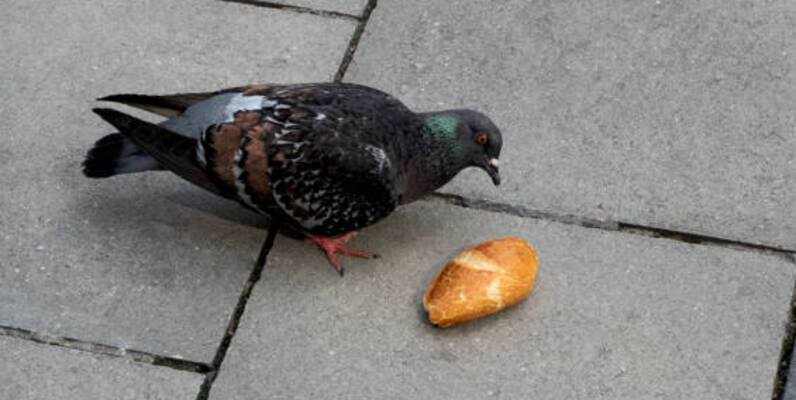


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score
from sklearn.tree import plot_tree



# Data Exploration

## Initial Analysis

In [2]:
pigeon_frame = pd.read_csv("train_bun.csv")

print("First 5 rows:")
print(pigeon_frame.head())

print("\nDataset shape:\n")
print(pigeon_frame.shape)

print("\nData types:n")
print(pigeon_frame.dtypes)

print("\nDescription:\n")
print(pigeon_frame.describe())

print("\nCount of unique values per column:\n")
print(pigeon_frame.nunique())



First 5 rows:
     id  bun_size  nearby_pigeons_count  time_of_day  feeding_spot_popularity  \
0  2099  2.117397                     5           11                 5.183150   
1  1332  1.850617                     5           17                 4.595100   
2   569  1.575189                     1            9                 1.810567   
3   599  0.790015                     8           12                 8.548308   
4  1050  1.003298                     4           19                 4.046106   

   distance_to_pigeons_m  is_raining  crumbs_on_ground  crowd_density  \
0               7.780918           0          5.472407              5   
1               3.644349           1          2.290217              2   
2               2.309359           0          3.719027              1   
3               5.182641           1          5.983987             10   
4               2.514642           0          3.413828              0   

   human_distance_m  noise_level  will_eat_bun  
0          

## Observations


We have 12 columns, with all of the data either being an integer or a float.

Since we have values on large ranges of numbers, the data should be normalised for better model performance. Our target feature, will_eat_bun, is a feature with a binary value, 1 for if the pigeon will eat the bun and 0 if not.

In [3]:
pigeon_frame.isnull()

,id,bun_size,nearby_pigeons_count,time_of_day,feeding_spot_popularity,distance_to_pigeons_m,is_raining,crumbs_on_ground,crowd_density,human_distance_m,noise_level,will_eat_bun
0,False,False,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...
1995,False,False,False,False,False,False,False,False,False,False,False,False
1996,False,False,False,False,False,False,False,False,False,False,False,False
1997,False,False,False,False,False,False,False,False,False,False,False,False
1998,False,False,False,False,False,False,False,False,False,False,False,False


We have no missing values, but that is to be expected as this dataset is artificial.

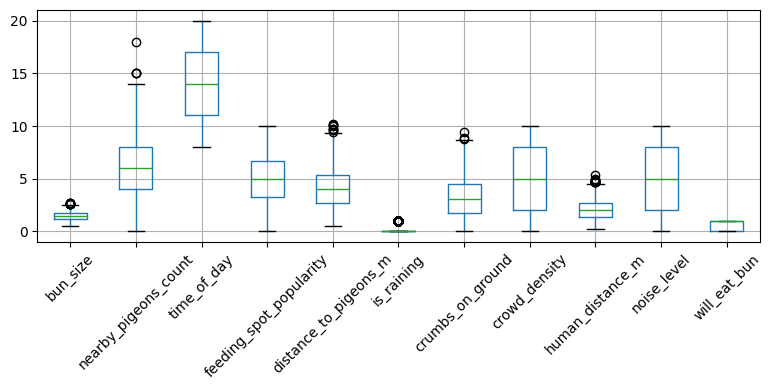

In [4]:
pigeon_frame.drop('id', axis=1).boxplot(figsize=(8, 4))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

We have some outliers, but not too dramatic. For this plot we removed the "id" column as it was skewing the visualisation due to it's high range of 1-2000.

Ready to move on to the next part!

# Training models (TODO ADD MORE METRICS THAN ACCURACY)

## KNN

Cross-Validation Scores: [0.83928571 0.78214286 0.81071429 0.83214286 0.79285714]
Mean CV Accuracy: 0.811 (+/- 0.022)
Accuracy: 0.830


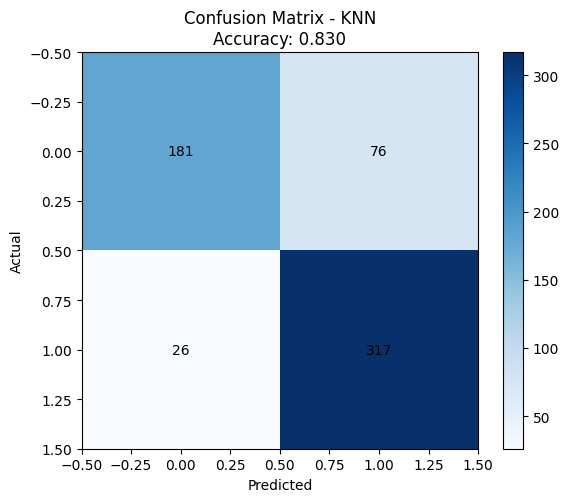

In [5]:
X = pigeon_frame.drop(["will_eat_bun", "id"], axis=1)  # Drop both target and id
y = pigeon_frame["will_eat_bun"]

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = KNeighborsClassifier(n_neighbors=5)

# Cross-validation on training data
cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5)
print(f"Cross-Validation Scores: {cv_scores}")
print(f"Mean CV Accuracy: {cv_scores.mean():.3f} (+/- {cv_scores.std():.3f})")

# Train on full training set and test
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.3f}")

# Create confusion matrix visualization
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
plt.imshow(cm, cmap='Blues', interpolation='nearest')
plt.colorbar()
plt.title(f'Confusion Matrix - KNN\nAccuracy: {accuracy:.3f}')
plt.xlabel('Predicted')
plt.ylabel('Actual')
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, str(cm[i, j]), ha='center', va='center')
plt.tight_layout()
plt.show()

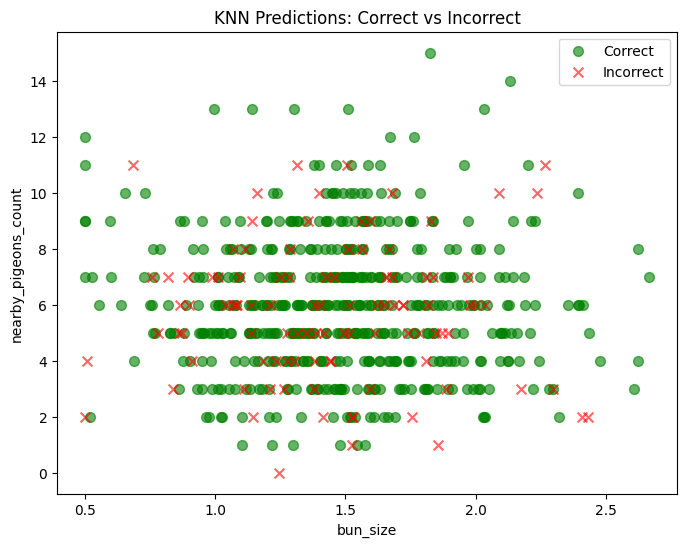

In [6]:
correct = y_test == y_pred

feature1 = X_test.iloc[:, 0]
feature2 = X_test.iloc[:, 1]

plt.figure(figsize=(8, 6))
plt.scatter(feature1[correct], feature2[correct], 
            alpha=0.6, label="Correct", color="green", s=50)
plt.scatter(feature1[~correct], feature2[~correct], 
            alpha=0.6, label="Incorrect", color="red", s=50, marker='x')

plt.xlabel(X_test.columns[0])
plt.ylabel(X_test.columns[1])
plt.title("KNN Predictions: Correct vs Incorrect")
plt.legend()
plt.show()

## Decision Tree

Cross-Validation Scores: [0.72142857 0.75714286 0.73928571 0.8        0.775     ]
Mean CV Accuracy: 0.759 (+/- 0.027)
Accuracy: 0.770


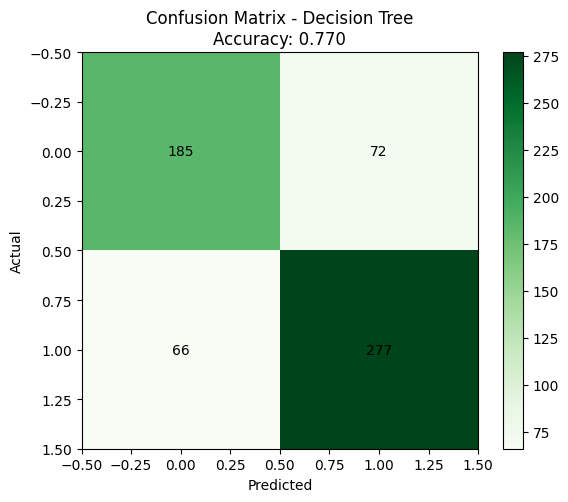

In [7]:
X = pigeon_frame.drop(["will_eat_bun", "id"], axis=1)  # Drop both target and id
y = pigeon_frame["will_eat_bun"]

#shplit the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

model = DecisionTreeClassifier(max_depth=5, random_state=42)

# Cross-validation on training data
cv_scores = cross_val_score(model, X_train, y_train, cv=5)
print(f"Cross-Validation Scores: {cv_scores}")
print(f"Mean CV Accuracy: {cv_scores.mean():.3f} (+/- {cv_scores.std():.3f})")

# Train on full training set and test
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.3f}")

# Create confusion matrix visualization
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
plt.imshow(cm, cmap='Greens', interpolation='nearest')
plt.colorbar()
plt.title(f'Confusion Matrix - Decision Tree\nAccuracy: {accuracy:.3f}')
plt.xlabel('Predicted')
plt.ylabel('Actual')
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, str(cm[i, j]), ha='center', va='center')
plt.tight_layout()
plt.show()

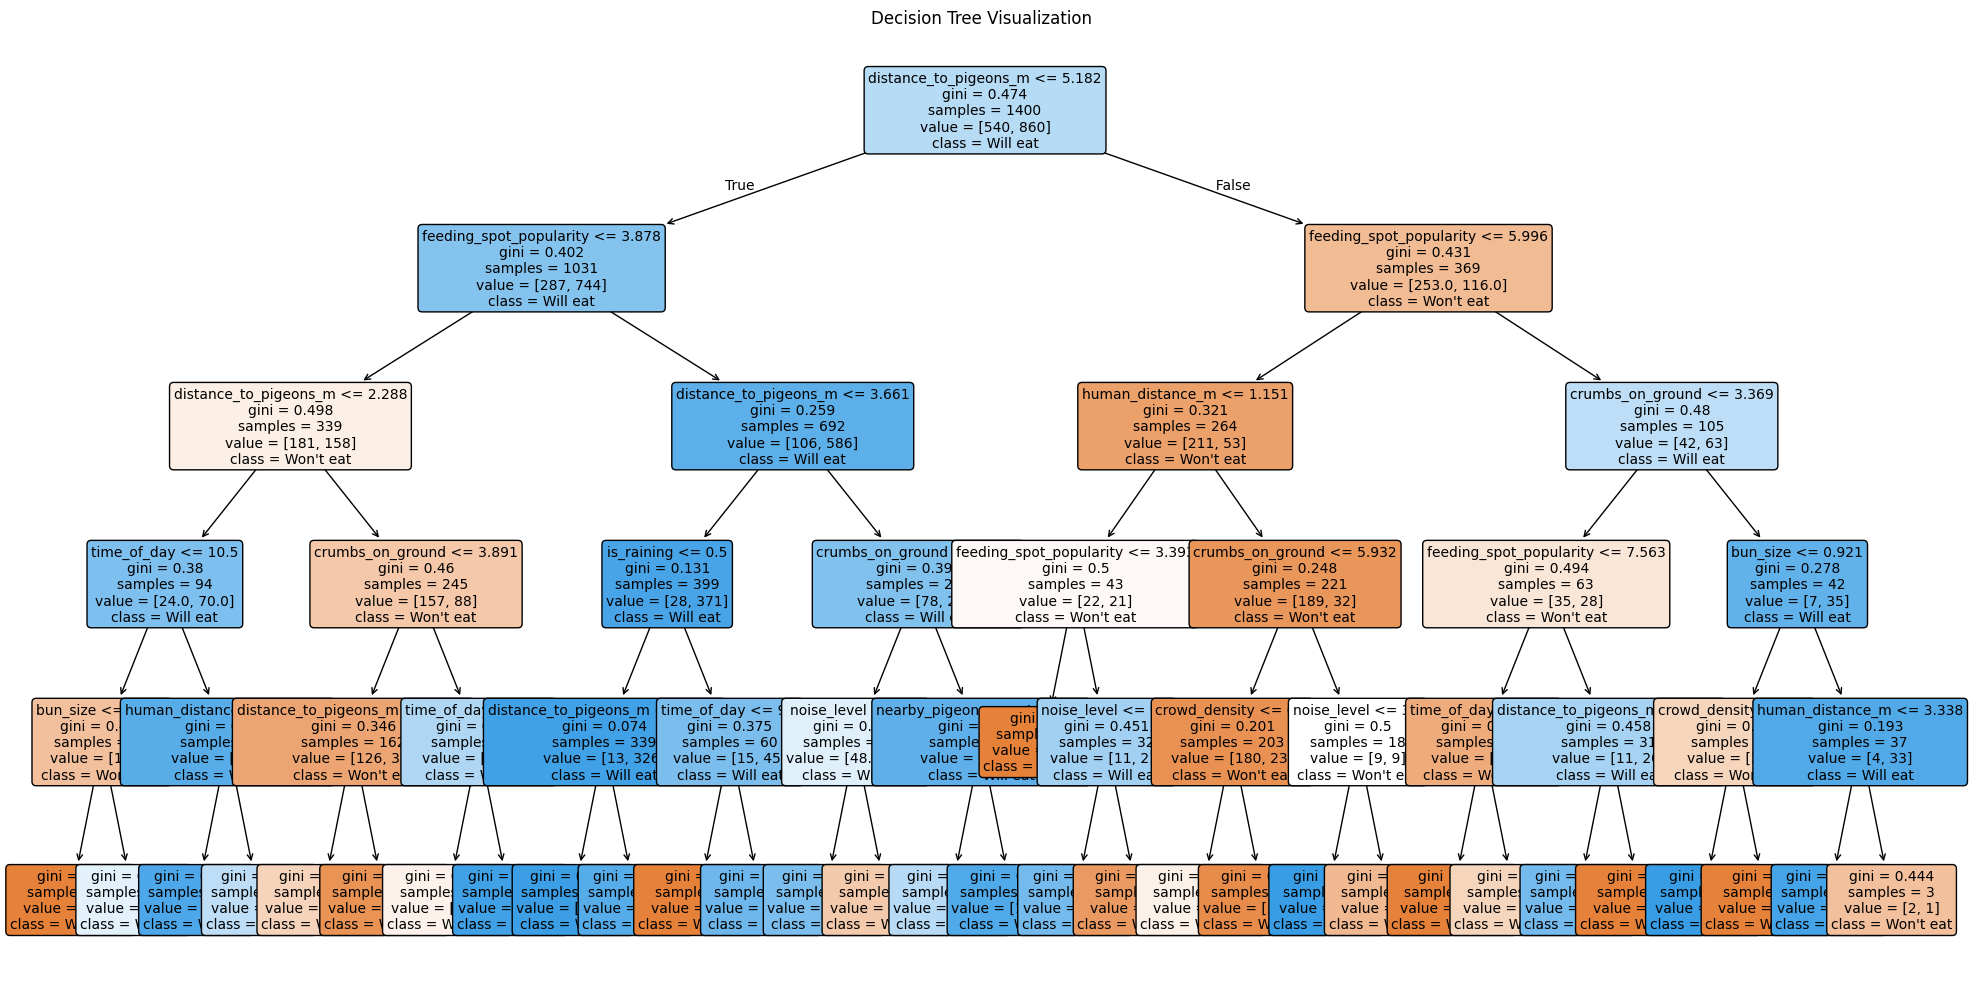

In [8]:
plt.figure(figsize=(20, 10))
plot_tree(model, 
          feature_names=X.columns, 
          class_names=['Won\'t eat', 'Will eat'],
          filled=True, 
          rounded=True,
          fontsize=10)
plt.title("Decision Tree Visualization")
plt.tight_layout()
plt.show()

## Naïve Bayes

Cross-Validation Scores: [0.85       0.86785714 0.86071429 0.84642857 0.85714286]
Mean CV Accuracy: 0.856 (+/- 0.008)
Accuracy: 0.858


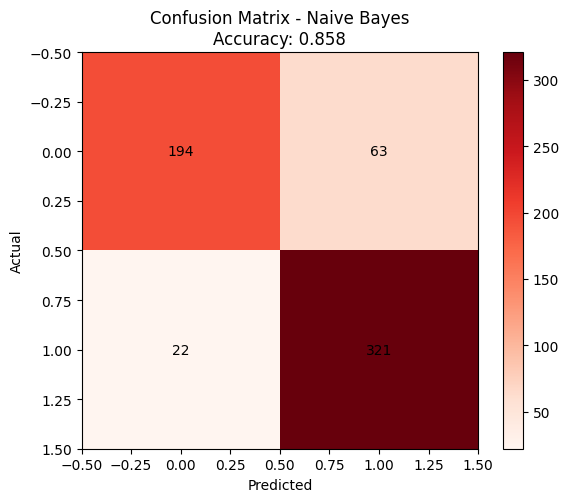

In [9]:
X = pigeon_frame.drop(["will_eat_bun", "id"], axis=1)  # Drop both target and id
y = pigeon_frame["will_eat_bun"]

#shplit the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

model = GaussianNB()

# Cross-validation on training data
cv_scores = cross_val_score(model, X_train, y_train, cv=5)
print(f"Cross-Validation Scores: {cv_scores}")
print(f"Mean CV Accuracy: {cv_scores.mean():.3f} (+/- {cv_scores.std():.3f})")

# Train on full training set and test
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.3f}")

# Create confusion matrix visualization
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
plt.imshow(cm, cmap='Reds', interpolation='nearest')
plt.colorbar()
plt.title(f'Confusion Matrix - Naive Bayes\nAccuracy: {accuracy:.3f}')
plt.xlabel('Predicted')
plt.ylabel('Actual')
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, str(cm[i, j]), ha='center', va='center')
plt.tight_layout()
plt.show()

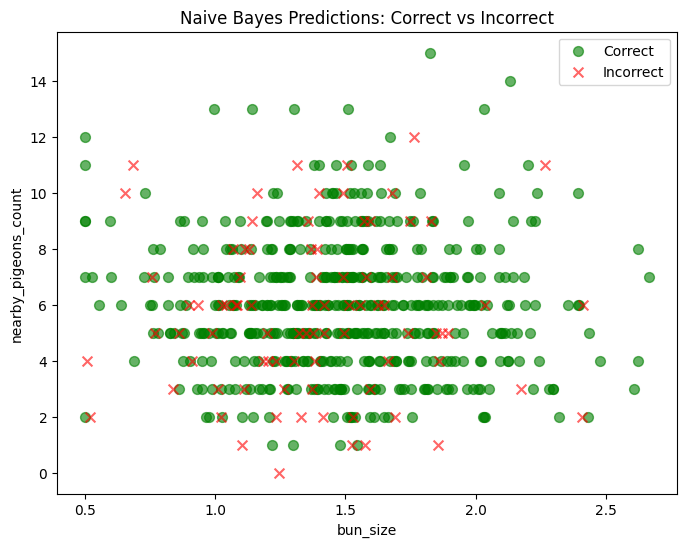

In [10]:
correct = y_test == y_pred

feature1 = X_test.iloc[:, 0]
feature2 = X_test.iloc[:, 1]

plt.figure(figsize=(8, 6))
plt.scatter(feature1[correct], feature2[correct], 
            alpha=0.6, label="Correct", color="green", s=50)
plt.scatter(feature1[~correct], feature2[~correct], 
            alpha=0.6, label="Incorrect", color="red", s=50, marker='x')

plt.xlabel(X_test.columns[0])
plt.ylabel(X_test.columns[1])
plt.title("Naive Bayes Predictions: Correct vs Incorrect")
plt.legend()
plt.show()